# Transition Path Sampling with Generative Flow Network

In [1]:
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt

# system config
seed = 3
device = "cuda" if torch.cuda.is_available() else "cpu"
save_dir = "results"

# model config
force = False
dist_feat = True

# sampling config
sigma = 0.5
num_steps = 1000
timestep = 0.01
num_samples = 512
temperature = 1200
kB = 8.6173303e-5  # Boltzmann constant in eV/K
kbT = kB * temperature  # in eV
std = np.sqrt(2 * kbT * timestep)
normal = torch.distributions.Normal(0, std)
start_position = torch.tensor([-1.118, 0], dtype=torch.float32).to(device)
target_position = torch.tensor([1.1180, 0], dtype=torch.float32).to(device)

# train config
log_z_lr = 0.01
policy_lr = 0.001
batch_size = 1024
num_rollouts = 20
buffer_size = 50000
trains_per_rollout = 100

In [2]:
def system(pos, force=True):
    if force:
        pos.requires_grad_(True)
    x = pos[:, 0]
    y = pos[:, 1]
    term_1 = 4 * (1 - x**2 - y**2) ** 2
    term_2 = 2 * (x**2 - 2) ** 2
    term_3 = ((x + y) ** 2 - 1) ** 2
    term_4 = ((x - y) ** 2 - 1) ** 2
    potential = (term_1 + term_2 + term_3 + term_4 - 2.0) / 6.0
    if force:
        force = -torch.autograd.grad(potential.sum(), pos)[0]
        return potential, force
    else:
        return potential

In [3]:
class Toy(nn.Module):
    def __init__(self):
        super().__init__()

        if force:
            self.output_dim = 2
        else:
            self.output_dim = 1

        if dist_feat:
            self.input_dim = 3
        else:  
            self.input_dim = 2

        self.mlp = nn.Sequential(
            nn.Linear(self.input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, self.output_dim, bias=False),
        )

        self.log_z = nn.Parameter(torch.tensor(0.0))

        self.to(device)

    def forward(self, pos):
        if not force:
            pos.requires_grad = True
        if dist_feat:
            dist = torch.norm(pos - target_position, dim=-1, keepdim=True)
            pos_ = torch.cat([pos, dist], dim=-1)
        else:
            pos_ = pos

        out = self.mlp(pos_.reshape(-1, self.input_dim))

        if not force:
            f = -torch.autograd.grad(
                out.sum(), pos, create_graph=True, retain_graph=True
            )[0]
        else:
            f = out.view(*pos.shape)

        return f

In [4]:
class ReplayBuffer:
    def __init__(self):
        self.positions = torch.zeros(
            (buffer_size, num_steps + 1, 2),
            device=device,
        )
        self.actions = torch.zeros(
            (buffer_size, num_steps, 2), device=device
        )
        self.log_reward = torch.zeros(buffer_size, device=device)

        self.idx = 0
        self.buffer_size = buffer_size
        self.num_samples = num_samples

    def add(self, data):
        indices = torch.arange(self.idx, self.idx + self.num_samples) % self.buffer_size
        self.idx += self.num_samples

        self.positions[indices], self.actions[indices], self.log_reward[indices] = data

    def sample(self):
        indices = torch.randperm(min(self.idx, self.buffer_size))[: self.num_samples]
        return self.positions[indices], self.actions[indices], self.log_reward[indices]

In [5]:
class FlowNetAgent:
    def __init__(self):
        self.policy = Toy()
        self.replay = ReplayBuffer()

    def sample(self, training=True):
        positions = torch.zeros(
            (num_samples, num_steps + 1, 2),
            device=device,
        )
        actions = torch.zeros(
            (num_samples, num_steps, 2),
            device=device,
        )
        noises = torch.normal(
            torch.zeros(
                (num_samples, num_steps, 2),
                device=device,
            ),
            torch.ones(
                (num_samples, num_steps, 2),
                device=device,
            ),
        )
        potentials = torch.zeros((num_samples, num_steps + 1), device=device)

        potential = system(start_position.unsqueeze(0), False)

        position = start_position.unsqueeze(0)
        positions[:, 0] = position
        potentials[:, 0] = potential


        for s in tqdm(range(num_steps), desc="Sampling"):
            noise = noises[:, s]
            bias = self.policy(position.detach()).squeeze().detach()
            potential, force = system(position)
            mean = position + force * timestep
            position = position + (force + bias) * timestep + std * noise
            positions[:, s + 1] = position
            potentials[:, s + 1] = potential
            actions[:, s] = position - mean

        log_md_reward = normal.log_prob(actions.detach())
        log_target_reward = (
            -0.5
            * torch.square(positions - (target_position.view(1, 1, -1)) / std).mean(2)
            / sigma
        )
        log_target_reward, last_idx = log_target_reward.max(1)
        log_reward = log_md_reward.mean((1, 2)) + log_target_reward

        if training:
            self.replay.add((positions.detach(), actions.detach(), log_reward.detach()))

        log = {
            "last_idx": last_idx,
            "positions": positions,
            "log_likelihood": log_md_reward.sum(-1).mean(1),
        }
        return log

    def train(self):
        optimizer = torch.optim.Adam(
            [
                {"params": [self.policy.log_z], "lr": log_z_lr},
                {"params": self.policy.mlp.parameters(), "lr": policy_lr},
            ]
        )

        positions, actions, log_reward = self.replay.sample()

        biases = self.policy(positions[:, :-1].detach())

        log_z = self.policy.log_z
        log_forward = normal.log_prob(actions-biases).mean((1, 2))

        loss = (log_z + log_forward - log_reward).square().mean()

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        return loss.item()

In [6]:
class Metric:
    def expected_distance(self, positions, last_idx):
        last_position = positions[torch.arange(num_samples), last_idx]
        dists = (last_position - target_position.unsqueeze(0)).square().mean((1))
        return dists.mean().item(), dists.std().item()

    def target_hit_percentage(self, positions, last_idx):
        last_position = positions[torch.arange(num_samples), last_idx]
        hits = (last_position - target_position.unsqueeze(0)).square().sum(1).sqrt() < 0.5
        thp = 100 * hits.sum() / len(hits)
        return thp
    
    def log_likelihood(self, log_likelihood):
        return log_likelihood.mean().item(), log_likelihood.std().item()

In [7]:
def plot_paths(save_dir, rollout, positions, last_idx):
    fig = plt.figure(figsize=(10, 5))
    positions = positions.detach().cpu().numpy()

    x = np.linspace(-1.5, 1.5, 400)
    y = np.linspace(-1.5, 1.5, 400)
    X, Y = np.meshgrid(x, y)
    
    term_1 = 4 * (1 - X**2 - Y**2) ** 2
    term_2 = 2 * (X**2 - 2) ** 2
    term_3 = ((X + Y) ** 2 - 1) ** 2
    term_4 = ((X - Y) ** 2 - 1) ** 2
    Z = (term_1 + term_2 + term_3 + term_4 - 2.0) / 6.0

    plt.contour(X, Y, Z, levels=100, cmap="RdGy")

    for i in range(positions.shape[0]):
        plt.scatter(positions[i, : last_idx[i], 0], positions[i, : last_idx[i], 1], s=3)
        plt.plot(
            positions[i, : last_idx[i], 0],
            positions[i, : last_idx[i], 1],
            linewidth=1,
            alpha=0.5,
        )

    plt.scatter(
        [start_position[0].item()],
        [start_position[1].item()],
        zorder=1e3,
        s=100,
        c="b",
        marker="o",
        label="start state",
    )
    plt.scatter(
        [target_position[0].item()], [target_position[1].item()], zorder=1e3, s=100, c="b", marker="*", label="end state"
    )

    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.savefig(f"{save_dir}/{rollout}.png")
    plt.close()
    return fig

Start training


Sampling: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 372.55it/s]


Train Rollout: 0, ED: 1.81 (±0.11), THP: 0.00, LL: 3.34 (±0.03)


Training: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 180.62it/s]


Rollout: 0, Loss: 102684.520390625


Sampling: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 520.32it/s]


Train Rollout: 1, ED: 1.79 (±0.11), THP: 0.00, LL: 3.34 (±0.03)


Training: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 190.08it/s]


Rollout: 1, Loss: 100987.48578125


Sampling: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 521.18it/s]


Train Rollout: 2, ED: 1.78 (±0.14), THP: 0.20, LL: 3.34 (±0.03)


Training: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 190.88it/s]


Rollout: 2, Loss: 96376.668203125


Sampling: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 525.02it/s]


Train Rollout: 3, ED: 1.73 (±0.15), THP: 0.20, LL: 3.34 (±0.03)


Training: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 190.81it/s]


Rollout: 3, Loss: 82689.906640625


Sampling: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 524.67it/s]


Train Rollout: 4, ED: 1.62 (±0.23), THP: 0.98, LL: 3.33 (±0.03)


Training: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 188.69it/s]


Rollout: 4, Loss: 50075.313203125


Sampling: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 527.57it/s]


Train Rollout: 5, ED: 1.03 (±0.68), THP: 28.71, LL: 3.32 (±0.03)


Training: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 191.06it/s]


Rollout: 5, Loss: 8692.238715820313


Sampling: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 522.28it/s]


Train Rollout: 6, ED: 0.17 (±0.38), THP: 86.33, LL: 3.31 (±0.03)


Training: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 191.72it/s]


Rollout: 6, Loss: 3720.9214672851563


Sampling: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 523.50it/s]


Train Rollout: 7, ED: 0.16 (±0.38), THP: 88.09, LL: 3.31 (±0.03)


Training: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 189.17it/s]


Rollout: 7, Loss: 5375.973037109375


Sampling: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 521.04it/s]


Train Rollout: 8, ED: 0.28 (±0.50), THP: 77.15, LL: 3.31 (±0.03)


Training: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 190.74it/s]


Rollout: 8, Loss: 5707.651220703125


Sampling: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 515.71it/s]


Train Rollout: 9, ED: 0.39 (±0.57), THP: 69.34, LL: 3.30 (±0.04)


Training: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 191.64it/s]


Rollout: 9, Loss: 5665.4749755859375


Sampling: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 522.72it/s]


Train Rollout: 10, ED: 0.49 (±0.61), THP: 61.52, LL: 3.30 (±0.03)


Training: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 188.66it/s]


Rollout: 10, Loss: 5218.631301269531


Sampling: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 523.39it/s]


Train Rollout: 11, ED: 0.66 (±0.65), THP: 48.83, LL: 3.29 (±0.03)


Training: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 191.02it/s]


Rollout: 11, Loss: 4943.473154296875


Sampling: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 521.03it/s]


Train Rollout: 12, ED: 0.72 (±0.65), THP: 44.53, LL: 3.29 (±0.04)


Training: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 191.72it/s]


Rollout: 12, Loss: 4916.575244140625


Sampling: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 505.86it/s]


Train Rollout: 13, ED: 0.71 (±0.65), THP: 45.31, LL: 3.29 (±0.03)


Training: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 179.68it/s]


Rollout: 13, Loss: 4953.539809570312


Sampling: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 519.96it/s]


Train Rollout: 14, ED: 0.75 (±0.65), THP: 42.38, LL: 3.29 (±0.03)


Training: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 188.41it/s]


Rollout: 14, Loss: 5020.558354492187


Sampling: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 518.33it/s]


Train Rollout: 15, ED: 0.71 (±0.64), THP: 45.31, LL: 3.30 (±0.04)


Training: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 188.39it/s]


Rollout: 15, Loss: 5125.110869140625


Sampling: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 521.54it/s]


Train Rollout: 16, ED: 0.71 (±0.64), THP: 45.51, LL: 3.29 (±0.04)


Training: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 190.44it/s]


Rollout: 16, Loss: 5240.051850585937


Sampling: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 522.83it/s]


Train Rollout: 17, ED: 0.71 (±0.66), THP: 46.29, LL: 3.29 (±0.03)


Training: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 187.83it/s]


Rollout: 17, Loss: 5268.914448242187


Sampling: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 522.34it/s]


Train Rollout: 18, ED: 0.76 (±0.65), THP: 42.38, LL: 3.29 (±0.04)


Training: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 188.63it/s]


Rollout: 18, Loss: 5236.99669921875


Sampling: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 523.66it/s]


Train Rollout: 19, ED: 0.73 (±0.65), THP: 43.75, LL: 3.29 (±0.03)


Training: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 190.19it/s]


Rollout: 19, Loss: 5302.751474609375


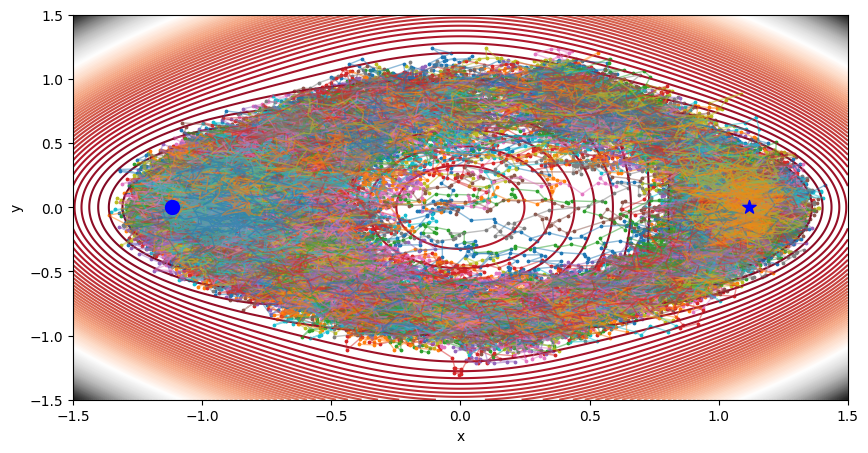

In [8]:
torch.manual_seed(seed)
agent = FlowNetAgent()
metric = Metric()
print("Start training")
for rollout in range(num_rollouts):

    log = agent.sample()
    dist, dist_std = metric.expected_distance(log["positions"], log["last_idx"])
    ll, ll_std = metric.log_likelihood(log["log_likelihood"])
    thp = metric.target_hit_percentage(log["positions"], log["last_idx"])
    print(f"Train Rollout: {rollout}, ED: {dist:.2f} (±{dist_std:.2f}), THP: {thp:.2f}, LL: {ll:.2f} (±{ll_std:.2f})")

    loss = 0
    for _ in tqdm(range(trains_per_rollout), desc="Training"):
        loss += agent.train()
    loss = loss / trains_per_rollout
    print(f"Rollout: {rollout}, Loss: {loss}")

plot_paths(save_dir, rollout, log["positions"], log["last_idx"])